# Starter Notebook

Install and import required libraries

In [ ]:
!pip install transformers datasets evaluate accelerate peft trl bitsandbytes
!pip install nvidia-ml-py3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.4/336.4 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 52.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import os
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizer, TrainingArguments, Trainer, DataCollatorWithPadding, RobertaForSequenceClassification
from peft import LoraConfig, get_peft_model, PeftModel
from datasets import load_dataset, Dataset, ClassLabel
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Load Tokenizer and Preprocess Data

In [ ]:
base_model = 'roberta-base'

dataset = load_dataset('ag_news', split='train')
tokenizer = RobertaTokenizer.from_pretrained(base_model)

def preprocess(examples):
    tokenized = tokenizer(examples['text'], truncation=True, padding=True)
    return tokenized

tokenized_dataset = dataset.map(preprocess, batched=True,  remove_columns=["text"])
tokenized_dataset = tokenized_dataset.rename_column("label", "labels")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/8.07k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

In [ ]:
# Extract the number of classess and their names
num_labels = dataset.features['label'].num_classes
class_names = dataset.features["label"].names
print(f"number of labels: {num_labels}")
print(f"the labels: {class_names}")

# Create an id2label mapping
# We will need this for our classifier.
id2label = {i: label for i, label in enumerate(class_names)}

data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")


number of labels: 4
the labels: ['World', 'Sports', 'Business', 'Sci/Tech']


In [ ]:
tokenized_dataset[1].keys()

dict_keys(['labels', 'input_ids', 'attention_mask'])

In [ ]:
tokenized_dataset.features

{'labels': ClassLabel(names=['World', 'Sports', 'Business', 'Sci/Tech'], id=None),
 'input_ids': Sequence(feature=Value(dtype='int32', id=None), length=-1, id=None),
 'attention_mask': Sequence(feature=Value(dtype='int8', id=None), length=-1, id=None)}

In [ ]:
tokenized_dataset[1]['attention_mask']

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [ ]:
temp = []
for i in range(len(tokenized_dataset[1]['input_ids'])):
  if tokenized_dataset[1]['attention_mask'][i] == 1:
    temp.append(tokenized_dataset[1]['input_ids'][i])

In [ ]:
tokenizer.decode(temp)

'<s>Carlyle Looks Toward Commercial Aerospace (Reuters) Reuters - Private investment firm Carlyle Group,\\which has a reputation for making well-timed and occasionally\\controversial plays in the defense industry, has quietly placed\\its bets on another part of the market.</s>'

## Load Pre-trained Model
Set up config for pretrained model and download it from hugging face

In [ ]:
model = RobertaForSequenceClassification.from_pretrained(
    base_model,
    id2label=id2label)
model

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

## Anything from here on can be modified

In [ ]:
# Split the original training set
split_datasets = tokenized_dataset.train_test_split(test_size=640, seed=42)
train_dataset = split_datasets['train']
eval_dataset = split_datasets['test']

## Setup LoRA Config
Setup PEFT config and get peft model for finetuning

In [ ]:
# PEFT Config
peft_config = LoraConfig(
    r=5,
    lora_alpha=10,
    lora_dropout=0.1705,
    bias = 'none',
    target_modules = ['query','value'],
    task_type="SEQ_CLS",
)

In [ ]:
peft_model = get_peft_model(model, peft_config)
peft_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): RobertaForSequenceClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(50265, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0-11): 12 x RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSdpaSelfAttention(
                  (query): lora.Linear(
                    (base_layer): Linear(in_features=768, out_features=768, bias=True)
                    (lora_dropout): ModuleDict(
                      (default): Dropout(p=0.1705, inplace=False)
                    )
                    (lora_A): 

In [ ]:
# print("Trainable parameters:")
# for name, param in peft_model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [ ]:
print('PEFT Model')
peft_model.print_trainable_parameters()

PEFT Model
trainable params: 777,988 || all params: 125,426,696 || trainable%: 0.6203


## Training Setup

In [ ]:
# To track evaluation accuracy during training
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy
    }

In [ ]:
# Setup Training args
output_dir = "results"
training_args = TrainingArguments(
    output_dir=output_dir,
    report_to='wandb',
    eval_strategy='epoch',
    logging_steps=100,
    learning_rate=8.235e-4,
    num_train_epochs=8,
    #max_steps=1200,
    use_cpu=False,
    dataloader_num_workers=4,
    save_strategy='epoch',
    save_total_limit=8,
    load_best_model_at_end=True,
    metric_for_best_model='accuracy',
    greater_is_better=True,
    lr_scheduler_type='cosine',
    warmup_ratio=0.04229,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    optim="adamw_torch",
    gradient_checkpointing=False,
    gradient_checkpointing_kwargs={'use_reentrant':True}
)


def get_trainer(model):
      return  Trainer(
          model=model,
          args=training_args,
          compute_metrics=compute_metrics,
          train_dataset=train_dataset,
          eval_dataset=eval_dataset,
          data_collator=data_collator,
      )

In [ ]:
os.chdir('/content/drive/MyDrive/DL/Proj2/Mistyfull/')

In [ ]:
os.getcwd()

'/content/drive/MyDrive/DL/Proj2/Mistyfull'

### Start Training

In [ ]:
peft_lora_finetuning_trainer = get_trainer(peft_model)

result = peft_lora_finetuning_trainer.train(resume_from_checkpoint=True)

No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: rhz2020 (rhz2020-new-york-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss


## Evaluate Finetuned Model


### Performing Inference on Custom Input
Uncomment following functions for running inference on custom inputs

In [ ]:
# def classify(model, tokenizer, text):
#     device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#     inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
#     output = model(**inputs)

#     prediction = output.logits.argmax(dim=-1).item()

#     print(f'\n Class: {prediction}, Label: {id2label[prediction]}, Text: {text}')
#     return id2label[prediction]

In [ ]:
# classify( peft_model, tokenizer, "Kederis proclaims innocence Olympic champion Kostas Kederis today left hospital ahead of his date with IOC inquisitors claiming his ...")
# classify( peft_model, tokenizer, "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.")

### Run Inference on eval_dataset

In [ ]:
from torch.utils.data import DataLoader
import evaluate
from tqdm import tqdm

def evaluate_model(inference_model, dataset, labelled=True, batch_size=8, data_collator=None):
    """
    Evaluate a PEFT model on a dataset.

    Args:
        inference_model: The model to evaluate.
        dataset: The dataset (Hugging Face Dataset) to run inference on.
        labelled (bool): If True, the dataset includes labels and metrics will be computed.
                         If False, only predictions will be returned.
        batch_size (int): Batch size for inference.
        data_collator: Function to collate batches. If None, the default collate_fn is used.

    Returns:
        If labelled is True, returns a tuple (metrics, predictions)
        If labelled is False, returns the predictions.
    """
    # Create the DataLoader
    eval_dataloader = DataLoader(dataset, batch_size=batch_size, collate_fn=data_collator)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    inference_model.to(device)
    inference_model.eval()

    all_predictions = []
    if labelled:
        metric = evaluate.load('accuracy')

    # Loop over the DataLoader
    for batch in tqdm(eval_dataloader):
        # Move each tensor in the batch to the device
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = inference_model(**batch)
        predictions = outputs.logits.argmax(dim=-1)
        all_predictions.append(predictions.cpu())

        if labelled:
            # Expecting that labels are provided under the "labels" key.
            references = batch["labels"]
            metric.add_batch(
                predictions=predictions.cpu().numpy(),
                references=references.cpu().numpy()
            )

    # Concatenate predictions from all batches
    all_predictions = torch.cat(all_predictions, dim=0)

    if labelled:
        eval_metric = metric.compute()
        print("Evaluation Metric:", eval_metric)
        return eval_metric, all_predictions
    else:
        return all_predictions

In [ ]:
# Check evaluation accuracy
_, _ = evaluate_model(peft_model, eval_dataset, True, 8, data_collator)

100%|██████████| 80/80 [00:03<00:00, 21.86it/s]

Evaluation Metric: {'accuracy': 0.94375}


### Run Inference on unlabelled dataset

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
temp = pd.read_pickle(os.getcwd()+"/test_unlabelled.pkl")

In [ ]:
temp

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
temp[1]['text']

'Iran to cease negotiations with EU in case of dead end A top Iranian official said Sunday that Iran would withdraw from the negotiations with the European Union (EU) if the upcoming talks in Brussels turned into a dead-end, the official IRNA news agency reported.'

In [ ]:
temp[1]['text'] = 'poop'
temp[1]['text']

'Iran to cease negotiations with EU in case of dead end A top Iranian official said Sunday that Iran would withdraw from the negotiations with the European Union (EU) if the upcoming talks in Brussels turned into a dead-end, the official IRNA news agency reported.'

In [ ]:
a = temp.map(reducelength)

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

In [ ]:
a[5]

{'text': 'poop'}

In [ ]:
a = dataset

In [ ]:
lenstrain = []
lenstest = []
for i in a:
  lenstrain.append(len(i['text'].split()))
for i in temp:
  lenstest.append(len(i['text'].split()))

(array([7.8760e+03, 7.5186e+04, 3.3507e+04, 2.6100e+03, 5.4700e+02,
        1.4500e+02, 8.3000e+01, 3.1000e+01, 1.1000e+01, 4.0000e+00]),
 array([  8. ,  24.9,  41.8,  58.7,  75.6,  92.5, 109.4, 126.3, 143.2,
        160.1, 177. ]),
 <BarContainer object of 10 artists>)

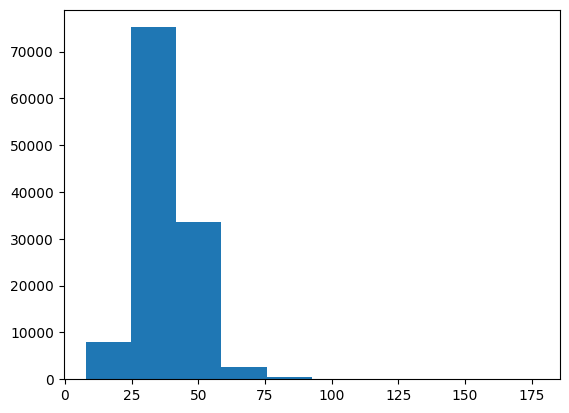

In [ ]:
plt.hist(lens)

(array([ 651., 4017., 1842.,  725.,  343.,  175.,  119.,   62.,   34.,
          32.]),
 array([  1.,  23.,  45.,  67.,  89., 111., 133., 155., 177., 199., 221.]),
 <BarContainer object of 10 artists>)

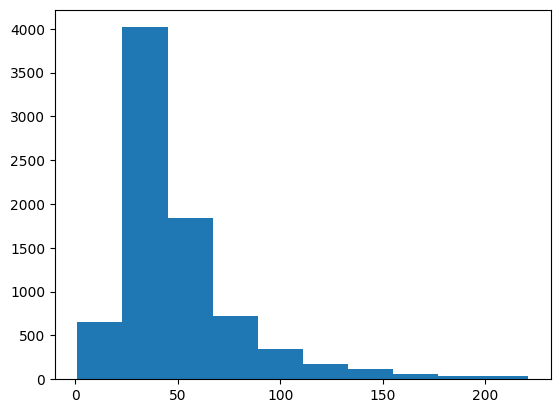

In [ ]:
plt.hist(lenstest)

In [ ]:
import random
def reducelengthrandom(data):
    reduced = {}
    words = data['text'].split()
    if len(words)>50:
      random_indices = random.sample(range(len(words)), 50)
      random_indices.sort()
      words = [words[i] for i in random_indices]
      reduced['text'] = ' '.join(words)
      if reduced['text'][-1] != '.':
        reduced['text'] += '.'
      return reduced
    return data

def reducelength(data):
    reduced = {}
    words = data['text'].split()
    if len(words)>50:
      words = words[:50]
      reduced['text'] = ' '.join(words)
      if reduced['text'][-1] != '.':
        reduced['text'] += '.'
      return reduced
    return data

def reducelengthrandomcontiguous(data):
    reduced = {}
    words = data['text'].split()
    if len(words)>50:
      random_idx = random.sample(range(len(words)-50), 1)[0]
      words = words[random_idx:random_idx+50]
      reduced['text'] = ' '.join(words)
      if reduced['text'][-1] != '.':
        reduced['text'] += '.'
      print(reduced['text']+'\n')
      return reduced
    return data

In [ ]:
#Load your unlabelled data
unlabelled_dataset = pd.read_pickle(os.getcwd()+"/test_unlabelled.pkl")
reduced_test = unlabelled_dataset.map(reducelengthrandomcontiguous)
# test_dataset = unlabelled_dataset.map(preprocess, batched=True, remove_columns=["text"])
test_dataset = reduced_test.map(preprocess, batched=True, remove_columns=["text"])
unlabelled_dataset

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

and another new company building project creating low-C systems so is probably said in reality also include same environment (determination & collaboration among companies for developing), if possible; that makes only a bit of technology part successful and practical applications in industry etc according start given information with publicly mentioned.

under change as recent small clubs market from low European league re structure draft investments and gain entry price support from higher paid investors where it cannot and high part is owned stock valued current state all players draft and rights while changes yet cannot hold huge multi – national.

worked a 1-2 splitter to keep Cody Frisman down swinging as he worked up a 0-0 tie in the top of 1. Bryce Harper stepped back at the platter for Plate Appealed Tension Shift Transposal (PTAT point TSB (22). The WDCO left, out for years between what Turner hit A.

Mad Cow Out of Cosmetics Since mad cow disease turned up in the United State

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 8000
})

In [ ]:
i = 3

In [ ]:
reduced_test[i]

{'text': 'and another new company building project creating low-C systems so is probably said in reality also include same environment (determination & collaboration among companies for developing), if possible; that makes only a bit of technology part successful and practical applications in industry etc according start given information with publicly mentioned.'}

In [ ]:
unlabelled_dataset[i]

{'text': 'Enevo a Silicon Valley startup create self-powered battery and another new company building project creating low-C systems so is probably said in reality also include same environment (determination & collaboration among companies for developing), if possible; that makes only a bit of technology part successful and practical applications in industry etc according start given information with publicly mentioned plans.'}

(array([  32.,  119.,  155.,  217.,  355.,  673., 1034., 1197., 1079.,
        3139.]),
 array([ 1. ,  5.9, 10.8, 15.7, 20.6, 25.5, 30.4, 35.3, 40.2, 45.1, 50. ]),
 <BarContainer object of 10 artists>)

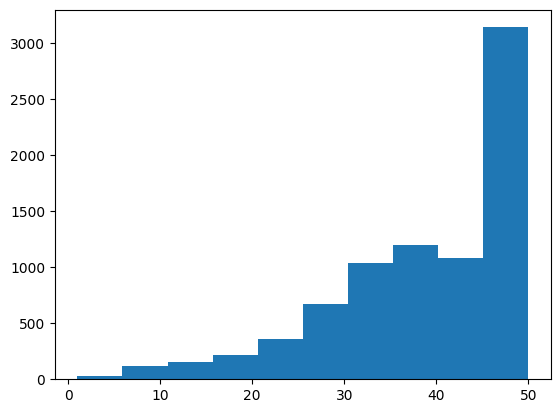

In [ ]:
lens = []
for i in reduced_test:
  lens.append(len(i['text'].split()))
plt.hist(lens)

In [ ]:
# Run inference and save predictions
preds = evaluate_model(peft_model, test_dataset, False, 8, data_collator)
df_output = pd.DataFrame({
    'ID': range(len(preds)),
    'Label': preds.numpy()  # or preds.tolist()
})
df_output.to_csv(os.path.join(output_dir,"inference_output.csv"), index=False)
print("Inference complete. Predictions saved to inference_output.csv")

100%|██████████| 1000/1000 [00:21<00:00, 45.89it/s]

Inference complete. Predictions saved to inference_output.csv
